## Data download

In [18]:
import os

if not os.path.exists('/./embeddings.zip'):
  data_set='kaggle competitions download -c quora-insincere-questions-classification'

  if not os.path.exists('/./kaggle.json'):
    from google.colab import files
    files.upload()
    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    !{data_set}
    !unzip -q quora-insincere-questions-classification
  else:
    !{data_set}
    !unzip quora-insincere-questions-classification.zip

Saving kaggle.json to kaggle.json
100% 6.03G/6.03G [01:20<00:00, 30.2MB/s]
100% 6.03G/6.03G [01:20<00:00, 80.4MB/s]


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [12]:
class CONFIGURATION:
  sample_size=100000

config=CONFIGURATION()

## Exploring the data

In [19]:
train = pd.read_csv('train.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [5]:
sincere_df = train[train.target==0]
insincere_df=train[train.target==1]

NameError: name 'train' is not defined

In [ ]:
sincere_df.question_text.values[10:20]

array(['What can you say about feminism?',
       'How were the Calgary Flames founded?',
       'What is the dumbest, yet possibly true explanation for Trump being elected?',
       'Can we use our external hard disk as a OS as well as for data storage.will the data be affected?',
       'I am 30, living at home and have no boyfriend. I would love a boyfriend and my own home. How can I progress my situation?',
       'What do you know about Bram Fischer and the Rivonia Trial?',
       'How difficult is it to find a good instructor to take a class near you?',
       'Have you licked the skin of a corpse?',
       'Do you think Amazon will adopt an in house approach to manufacturing similar to the Tesla or Space X business models?',
       'How many baronies might exist within a county palatine?'],
      dtype=object)

In [ ]:
insincere_df.question_text.values[10:20]

array(['Would Europeans continue to participate in the Arab war for the destruction of Israel and killing all the Jews, if they knew that god himself defends Israel and he will do to Europeans what the Arabs want to do to the Jews?',
       'Why are Americans, British, Canadians, Australians and New Zealanders considered to be separate nations even when they all speak the same language?',
       'If both Honey Singh and Justin Bieber fall from the 5th floor, who will survive?',
       'Why are liberal minorities so voilent towards poeple with diffrent poltical beleifs? Should supporting trump be a sentence to be imprisoned or savegely attacked?',
       "Can we all now admit that President Trump doesn't really want Congress to pass legislation replacing DACA to protect dreamers?",
       'The American economy is growing under Trump’s presidency, why do people still hate Trump as a president?',
       "Why don't poor countries print more money to use for paying for education, etc.?",
  

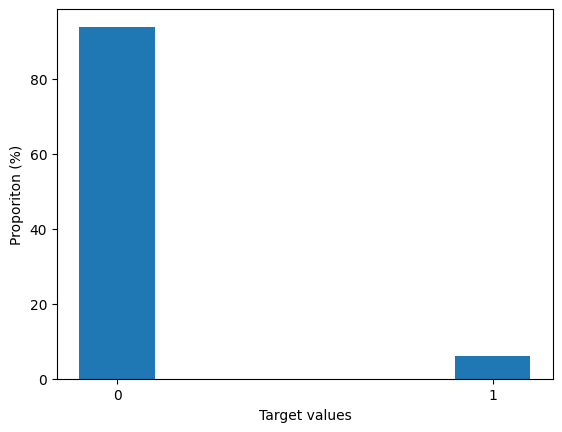

In [ ]:
proportion = 100*train.target.value_counts(normalize=True)
plt.bar(proportion.index, proportion.values,width=0.2)
plt.ylabel('Proporiton (%)')
plt.xlabel('Target values')
plt.xticks([0,1])
plt.show()

## Text preprocessing
1. Tokenization
2. Filtering Stopwords
3. Stemming

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### 1. Tokenization

In [ ]:
q0=sincere_df['question_text'].values[0]
q1 = insincere_df['question_text'].values[0]

In [ ]:
q0_tok = word_tokenize(q0)
q1_tok = word_tokenize(q1)

#### 2. Filtering Stopwords

In [ ]:
english_stopwords = stopwords.words('english')
# function to filter out stop words
def filter_stopwords(tokens):
  return [word for word in tokens if word.lower() not in english_stopwords]

In [ ]:
q0_stop=filter_stopwords(q0_tok)
q1_stop = filter_stopwords(q1_tok)

#### 3. Stemming

In [ ]:
stemmer = SnowballStemmer(language='english')
q0_stm=[stemmer.stem(word) for word in q0_stop]
q1_stm = [stemmer.stem(word) for word in q1_stop]

In [ ]:
stemmer.stem('going')

'going to lahor'

## Bag of Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer=CountVectorizer()
type(vectorizer)

sklearn.feature_extraction.text.CountVectorizer

In [ ]:
vectorizer=CountVectorizer()

corpus = [
       'This is the first document.',
     'This is the second second document.',
     'And the third one.',
     'Is this the first document?',
 ]

X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names_out())
X.toarray()

['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']


array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 2, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]])

In [ ]:
X.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 2, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]])

In [ ]:
corp_tok=word_tokenize(','.join(corpus))
corp_wo_stp = filter_stopwords(corp_tok)
set(corp_tok)

{',',
 '?',
 'And',
 'Is',
 'This',
 'document',
 'document.',
 'first',
 'is',
 'one.',
 'second',
 'the',
 'third',
 'this'}